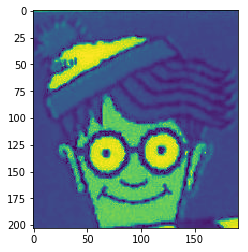

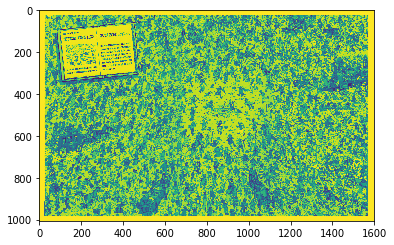

500
--
(455.0640869140625, 286.654541015625)
(335.9232482910156, 122.34241485595703)
(406.0, 157.0)
(315.187255859375, 114.04801940917969)
(141.0, 114.0)
(322.0, 171.0)
(216.0, 295.0)
(317.2608337402344, 124.416015625)
(148.0, 109.0)
(569.825439453125, 729.0779418945312)
(205.0, 290.0)
(953.8561401367188, 588.9024658203125)
(423.0, 204.0)
(320.0, 230.0)
(730.9691162109375, 361.9013671875)
(321.0, 236.0)
(128.16000366210938, 144.0)
(134.40000915527344, 286.8000183105469)
(123.60000610351562, 144.0)


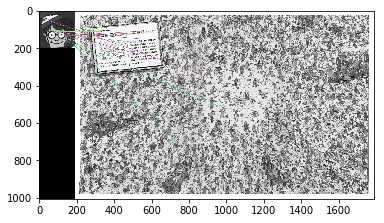

(<matplotlib.image.AxesImage at 0x7fd04023bba8>, None)

In [1]:
"""
Running ORB detector/descriptor
SURF can be run by using cv2.xfeatures2d.SURF_create(), but ORB does better, so i only included that.
"""

import numpy as np
import cv2
from matplotlib import pyplot as plt
import cyvlfeat as vlfeat

img1 = cv2.imread('templates/waldo/032/0.jpg',0)
plt.imshow(img1),plt.show()

img2 = cv2.imread('datasets/JPEGImages/003.jpg',0)
plt.imshow(img2),plt.show()

orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = bf.match(des1,des2)

matches.sort(key=lambda x: x.distance, reverse=False)

matches = matches[:int(len(matches)*0.1)]

print(len(kp2))
print("--")

for match in matches:
    print(kp2[match.trainIdx].pt)
    
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None, flags=2)
    
# you'll have to zoom in a lot to see the matched keypoints
plt.imshow(img3),plt.show()

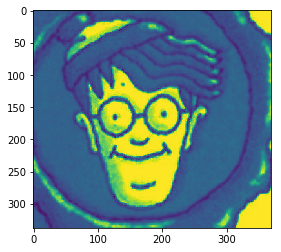

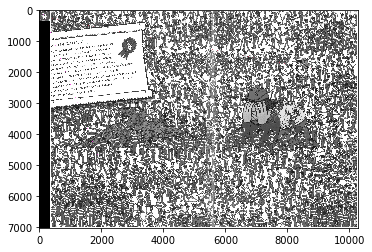

(<matplotlib.image.AxesImage at 0x7fd04018b9b0>, None)

In [2]:
"""
I was just testing out different approaches to detect, match and draw the matches.
This is a mixture of many different solutions on the internet and is very convoluted. 
It can be ignored for now.
"""

import numpy as np
import cv2
from matplotlib import pyplot as plt

def filter_matches(kp1, kp2, matches, ratio = 0.75):
    mkp1, mkp2 = [], []
    filtered = []
    for m in matches:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            m = m[0]
            mkp1.append( kp1[m.queryIdx] )
            mkp2.append( kp2[m.trainIdx] )
            filtered.append(m)
#     kp_pairs = zip(mkp1, mkp2)
    return (mkp1,mkp2,filtered)


def explore_match(win, img1, img2, kp_pairs, status = None, H = None):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    vis = numpy.zeros((max(h1, h2), w1+w2), numpy.uint8)
    vis[:h1, :w1] = img1
    vis[:h2, w1:w1+w2] = img2
    vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)

    if H is not None:
        corners = numpy.float32([[0, 0], [w1, 0], [w1, h1], [0, h1]])
        corners = numpy.int32( cv2.perspectiveTransform(corners.reshape(1, -1, 2), H).reshape(-1, 2) + (w1, 0) )
        cv2.polylines(vis, [corners], True, (255, 255, 255))

    if status is None:
        status = numpy.ones(len(kp_pairs), numpy.bool_)
    p1 = numpy.int32([kpp[0].pt for kpp in kp_pairs])
    p2 = numpy.int32([kpp[1].pt for kpp in kp_pairs]) + (w1, 0)

    green = (0, 255, 0)
    red = (0, 0, 255)
    white = (255, 255, 255)
    kp_color = (51, 103, 236)
    for (x1, y1), (x2, y2), inlier in zip(p1, p2, status):
        if inlier:
            col = green
            cv2.circle(vis, (x1, y1), 2, col, -1)
            cv2.circle(vis, (x2, y2), 2, col, -1)
        else:
            col = red
            r = 2
            thickness = 3
            cv2.line(vis, (x1-r, y1-r), (x1+r, y1+r), col, thickness)
            cv2.line(vis, (x1-r, y1+r), (x1+r, y1-r), col, thickness)
            cv2.line(vis, (x2-r, y2-r), (x2+r, y2+r), col, thickness)
            cv2.line(vis, (x2-r, y2+r), (x2+r, y2-r), col, thickness)
    vis0 = vis.copy()
    for (x1, y1), (x2, y2), inlier in zip(p1, p2, status):
        if inlier:
            cv2.line(vis, (x1, y1), (x2, y2), green)
    cv2.imshow(win, vis)   
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def draw_matches(window_name, kp_pairs, img1, img2):
    """Draws the matches for """
    mkp1, mkp2 = zip(*kp_pairs)

    p1 = numpy.float32([kp.pt for kp in mkp1])
    p2 = numpy.float32([kp.pt for kp in mkp2])

    if len(kp_pairs) >= 4:
        H, status = cv2.findHomography(p1, p2, cv2.RANSAC, 5.0)
    else:
        H, status = None, None
    if len(p1):
        explore_match(window_name, img1, img2, kp_pairs, status, H)

img1 = cv2.imread('templates/waldo/001/0.jpg',0)
plt.imshow(img1),plt.show()

img2 = cv2.imread('datasets/JPEGImages/001.jpg',0)
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

matcher = cv2.BFMatcher(cv2.NORM_L2)

matches = matcher.knnMatch(des1, des2, k=2) 

good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)
                
# M, mask = cv2.findHomography(np.asarray(kp1), np.asarray(kp2), cv2.RANSAC, 5.0)


img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,flags=2)

# if kp_pairs:
#     draw_matches('Matching Features', kp_pairs, img1, img2)    
# else:
#     print("No matches found")

# kp1_sorted = sorted(kp1, key = lambda x:x.pt[0])

# for kp in kp1_sorted:
#     print(kp.pt)

# # create BFMatcher object
# bf = cv2.BFMatcher()

# # Match descriptors.
# matches = bf.knnMatch(des1,des2, k=2)

# # Apply ratio test
# good = []
# for m,n in matches:
#     if m.distance < 0.7*n.distance:
#         good.append(m)

# src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
# dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

# M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
# matchesMask = mask.ravel().tolist()

# h,w = img1.shape
# pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
# dst = cv2.perspectiveTransform(pts,M)

# img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

# # Sort them in the order of their distance.
# matches = sorted(matches, key = lambda x:x.distance)

# for i,match in enumerate(matches):
#     if i==10:
#         break
#     print(f"{kp2[match.trainIdx].pt}, {match.distance}")

    
# draw_params = dict(matchColor = (0,255,0), # draw matches in green color
#                    singlePointColor = None,
#                    matchesMask = matchesMask, # draw only inliers
#                    flags = 2)

# img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.imshow(img3, 'gray'),plt.show()

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
import cyvlfeat as vlfeat
from sklearn.svm import LinearSVC, SVC
import os.path as osp
from skimage import filters
from skimage.feature import corner_peaks
from skimage.io import imread
import pickle
from random import shuffle
from scipy.spatial.distance import cdist

/Users/yash/anaconda3/envs/project/lib/python3.6/site-packages/scipy/__init__.py:115: UserWarning: Numpy 1.13.3 or above is required for this version of scipy (detected version 1.13.1)
  UserWarning)


In [24]:
def bags_of_sifts(image_paths=[], vocab_filename='', img=None):

    with open(vocab_filename, 'rb') as f:
        vocab = pickle.load(f)

    vocab_size = vocab.shape[0]
#     print(vocab_size)
    feats = []
    
    if len(image_paths) == 0:
        image_paths = ['']
    
    for path in image_paths:
        image = np.asarray(plt.imread(path)) if path != '' else img
        img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        (frames, descriptors) = vlfeat.sift.dsift(img_gray, fast=True, step=10)
        
        samples = descriptors
        
        D = cdist(samples, vocab)
        
        closest_words = np.argmin(D, axis=1)

#         for i in range(D.shape[0]):
#             min_index = np.argmin(D[i])
#             histogram[min_index]+=1

        histogram, bin_edges = np.histogram(closest_words, bins=np.arange(0, vocab_size+1))
#         print(histogram)

        if np.linalg.norm(histogram) == 0.0:
            print(descriptors.shape)
            print(D.shape)
            print(np.linalg.norm(histogram))
            print(img_gray.shape)
            print("--")
            
            
        histogram = histogram / np.linalg.norm(histogram)
        feats.append(histogram)
        
    N = len(image_paths)
    d = vocab_size
    feats = np.asarray(feats)
    feats = feats.reshape((N,d))
    return feats


def build_vocabulary(image_paths, vocab_size):
    dim = 128     
    vocab = np.zeros((vocab_size,dim))
    sift_features = []

    for path in image_paths:
        image = np.asarray(plt.imread(path))
        img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        (frames, descriptors) = vlfeat.sift.dsift(img_gray, fast=True, step=5)

        samples = np.random.permutation(descriptors)[:20]

        for descriptor in samples:
            sift_features.append(descriptor)

    sift_features = np.asarray(sift_features).astype('float64').reshape((-1,128))
    vocab = vlfeat.kmeans.kmeans(sift_features, vocab_size)

    return vocab


def svm_classify(train_image_feats, train_labels, test_image_feats):
    categories = list(set(train_labels))
    test_labels = []
    
    clf = LinearSVC(C=2)
    clf.fit(train_image_feats, train_labels)
    test_labels = clf.predict(test_image_feats)

    return test_labels


def test_accuracy(test_labels, predicted_labels):
    num_correct = 0
    for i,label in enumerate(test_labels):
        if (predicted_labels[i] == label):
            num_correct += 1
    return num_correct/len(test_labels)

In [3]:
waldo_paths = []
wenda_paths = []
wizard_paths = []
all_paths = []

test_image_paths = []
with open('datasets/ImageSets/val.txt') as file:
    for img_id in file.readlines():
        img_id = img_id.rstrip()
        test_image_paths.append('datasets/JPEGImages/{}.jpg'.format(img_id))

file.close()


template_dirs = ["templates/waldo","templates/wenda","templates/wizard"]

for i in range(len(template_dirs)):
    for img_id in os.listdir(template_dirs[i]):
        path_to_dir = os.path.join(template_dirs[i], '{}'.format(img_id)).rstrip()
        if not os.path.isdir(path_to_dir):
            continue
        list_of_files = os.listdir(path_to_dir)
        for file_name in list_of_files:
            all_paths.append(os.path.join(path_to_dir, '{}'.format(file_name)).rstrip())
            if i==0:
                waldo_paths.append(os.path.join(path_to_dir, '{}'.format(file_name)).rstrip())
            if i==1:
                wenda_paths.append(os.path.join(path_to_dir, '{}'.format(file_name)).rstrip())
            if i==2:
                wizard_paths.append(os.path.join(path_to_dir, '{}'.format(file_name)).rstrip())

# print(sorted(all_paths))
print(len(waldo_paths))
print(len(wenda_paths))
print(len(wizard_paths))

137
43
27


In [4]:
# get vocab
print('Using the BAG-OF-SIFT representation for images')

vocab_filename = 'vocab.pkl'

# print('No existing visual word vocabulary found. Computing one from training images')
vocab_size = 200  # Larger values will work better (to a point) but be slower to compute
vocab = build_vocabulary(all_paths,vocab_size)
print(np.isnan(vocab).any())
    
with open(vocab_filename, 'wb') as f:
    pickle.dump(vocab, f)

    print('{:s} saved'.format(vocab_filename))

Using the BAG-OF-SIFT representation for images
False
vocab.pkl saved


In [6]:
#get bags of sifts
template_percentage = 0.6

print(f"all_feats = {len(all_paths)}")

# waldo_feats = bags_of_sifts(waldo_paths,vocab_filename)
# wenda_feats = bags_of_sifts(wenda_paths,vocab_filename)
# wizard_feats = bags_of_sifts(wizard_paths,vocab_filename)

# print(np.isnan(waldo_feats).any())
# print(np.isnan(wenda_feats).any())
# print(np.isnan(wizard_feats).any())

# print(waldo_feats)
# print(wenda_feats)
# print(wizard_feats)


waldo_feats = bags_of_sifts(waldo_paths[:int(len(waldo_paths)*template_percentage)],vocab_filename)
wenda_feats = bags_of_sifts(wenda_paths[:int(len(wenda_paths)*template_percentage)],vocab_filename)
wizard_feats = bags_of_sifts(wizard_paths[:int(len(wizard_paths)*template_percentage)],vocab_filename)

training_feats = []
training_feats.extend(waldo_feats)
training_feats.extend(wenda_feats)
training_feats.extend(wizard_feats)

# print(len(waldo_feats))
# print(len(wenda_feats))
# print(len(wizard_feats))
print("--\ntest_feats_lengths")

# test_image_feats 
waldo_test_feats = bags_of_sifts(waldo_paths[int(len(waldo_paths)*template_percentage):len(waldo_paths)],vocab_filename)
wenda_test_feats = bags_of_sifts(wenda_paths[int(len(wenda_paths)*template_percentage):len(wenda_paths)],vocab_filename)
wizard_test_feats = bags_of_sifts(wizard_paths[int(len(wizard_paths)*template_percentage):len(wizard_paths)],vocab_filename)

test_feats = []
test_feats.extend(waldo_test_feats)
test_feats.extend(wenda_test_feats)
test_feats.extend(wizard_test_feats)

#set training labels
train_labels = []
train_labels.extend(["waldo"]*len(waldo_feats))
train_labels.extend(["wenda"]*len(wenda_feats))
train_labels.extend(["wizard"]*len(wizard_feats))

# print(len(waldo_test_feats))
# print(len(wenda_test_feats))
# print(len(wizard_test_feats))
print("--\ntest_labels lengths")

ground_truth_test_labels = []
ground_truth_test_labels.extend(["waldo"]*len(waldo_test_feats))
ground_truth_test_labels.extend(["wenda"]*len(wenda_test_feats))
ground_truth_test_labels.extend(["wizard"]*len(wizard_test_feats))

print(len(ground_truth_test_labels))

print(len(train_labels))
print(len(training_feats))
print("--")

print("done")

all_feats = 207
200
[13 19  7  0 14  3  0  9  3  5 16 16  5  0 11  6  7  6  3 16 13  3  8 10  2
 22  3  8  1  3  7  1 12 13  7  8  4  0  5 17 16  5  1 11  4  1 20 20 12  9
  6  4  0  4  2 11 20 12  4  3 15  3 11 12  6  1 14  2  8  0  1 13  2  3  3
  3  0  2 11 21  4 11  6  4  6  3 11 21 20  3  4  8  4  1 12 12  8 11  9  6
 10  8  5 10  1  2  0  2  5  4  9  7  3 11  8 15 13  9  5  6  0  6  4  7  6
  9  0 12  6  7  4  5 10  3 18 24  2  4  2  7 11  5  2 12 21 18  4  8  3  4
  3  9  1  5  4  1  6 13 16  1  7  4 11 25  4  5 18 18 12  9  3  5  7 13  5
  4  7  0  9  6  6  1  4  8  6 23  4  3  1 12  3  0  2 11  8  5  5 14  4  8]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 

[37 23 30  5 25 17  0 15 26 20 10 48 34  0 27 29 33 32 37 12 16  7 24 21  4
 12 16 29  9 22 41 13 18 13 18 32 23 12 24 20 15 21  7 36 39  4 33 11 28 22
 37 10 24 32 25 41 19 30 49 19 20 26 70 29 20  3 16 32 15 36 13 30  7 24 12
 30  1  2 11 18 31 43  8 13 17 19 12 61 13 11 19 25 11 19 38 26 55 25 19 24
 35 86 13 26 14  7  2  4  2 22 26 19 14 51 23 25 39 39 12 28  3 44 24 25 37
 31  0 57 17  6 15 31 39  6 11 13 15 17 19 14 11  6  1 16 27 54 28 20 30 11
  7 38 20 24 10 18 21 45 18  8  8  6 48 14 25 25 25 20 46 35 15 72 13 83 32
 16 28  8 12 31 20 19 46 45 38 25 24  8 27 32  5  0 13 23 27 35 24 22  9 40]
[46 11 27  2 18  7  0 29 17 20 12 37 30  1 25 14  8 30 24 14 18  3 13 10  2
  9 19 19  5 26 28 10 19 13 15 11  6  8 15 19  8 24  6 24 38  8 19 24  9 17
 27 14 14 16 25 15 11 33 25  8 15 19 59 22 17 10 13 21 12 36  9 27  4 19 13
 29  0  1  7  9 18 29  6 12 21 30 11 73 15 19 14 11 13 23 46 23 25 17 44 12
 27 78 11 22 21  3  0  4  3 18 35 20 12 46 16 17 27 34  0 22  4 32 24 18 39
 29  1 38 1

[ 48  13  22   0  23  17   1  27  25  14  11  20  24   0  30  16  31  39
  24   8  20   2  13  15   4  17  26  16   5  23  39  15  23  18  17  19
  23  12  15  24  16  30   5  25  39   5  33  14  12  20  26  14  24  20
  16  27  15  42  22  15  13  19  66  19  16  17  18  21  13  38   9  24
   4  13   5  28   2   0   8  10  22  23   7  23  18  19   7  57   9  21
  25  16  18  23  41  17  48  27  26  23  30 100  14  24  15   3   0   7
   5  27  38  25  16  44  23  13  41  35   7  22   2  35  29  16  27  28
   0  33  13   5  25  22  34   2   8  10  15  18  15   7   7  10   4  14
  19  35  11  14  18  18  12  33  27  21  11  17  14  45  16  10   3   4
  41  12  25  11  24  13  59  43  13  51  18  84  20   5  24   5  16  30
  21  15  40  34  25  19  23  15  19  29   3   1   8  24  45  28  19  12
  10  33]
[ 42  12  34   5  27  13   0  33  28  13   9  26  23   0  24   9  21  41
  28  18  26   1  13  26   4  12  21  13   7  29  30   7  22  12  13  22
  14  10  14  23  10  31   3  30  49   9 

[24 18  8  0 16  4  0 14  9 13 24 28 12  2 25  3 20  8  5 18 10  7 17 31  1
 29  9 13  0 15 14  4 49 19 13  6  4  3  6 22 11  3  3 24 22  4 49 42 21 14
  4  5  5 10  7 18 25 20  8  4 17  3 16 15 17  3 19  8 10  9  2 14  5 12  4
 11  0  2 12 25  7 18  9  9  8  4  7 11 49 11  7 12 10  7 18 25 33  7 13  5
 15 15  7 14  7  1  1  7  1 12  9  9  8 18  4 12 24  9  2 10  1 14  5 17  9
 12  0 22 23  6 14  5 10  7 40 38  5  7  9  5 11  8  6 10 28 19 11 23  7  6
  5 23  6 11  0  1 10 13 17  2  3  3 15 25  5  7 25 16 12 20  7 13 17 15  7
  1 10  1 16  4  6  5  3 12  7 26  3  5  4 17  4  0  3 11  7  3 18 23  0  6]
[10 10  4  0  3  1  4  6  3  3  4  2  2  0  1  0  3  3  2  7  4  1  3 10  2
  7  0  5  0  4  5  2  6  1  8  1  2  4  7  7  2  1  0  1  7  0 17 11  2  5
  4  4  8  0  6  1  3  3  0  0  6  4  5  4 13  6 15  1 11  3  0  7  1  3  5
  3  0  6 10  7  0  7  7  1  4  3  6  5  9  1  3  3  0  2 11  4  3 10  6  5
  4  1  5  3  2  2  0  0  2  7  6  5  3  1  5  5  2  3  0  6  0  0  3  1  6
  6  0  2  

[ 64  42  17   1  16  22 373  29  10   8  27  48   5   1   4   5   8  29
   7  49  28   4  38  40   2  37   8  47   0  18  18   4  44  13  51  15
   6  12  20  42  10  22   1  14  17   1  53  59  48  34  36  10  11   7
   9   8   9  16   9   6  39  14  14  21  43   4  33   2  23  22   4  42
  12   5  11  18   1  17  28  37   5  25  17  10   8  22  22  28  36   7
  11   6   8   8  76  17  20  36  34   5  13  11  16  20  13   2   0   3
   2  12  37  17   6  12   9  25   5  33   3   9   0   6   2  10  27  46
   0   9  40  28  28   8  17   4  36  28  10   6   6   8  20  17   1  25
  56  39  18  22   8  15   5   7   4  20   1   3   3   6  32   0  18   3
  27  27  11   3  38  50   1   9   4  14  28  10  10   5  15   1  15   0
  11   6  23  16  17  54  13   4   2  68   2   2   9  14  12   1   6  39
   0  24]
[ 8 10  5  1  7  4  5 10  5  3 12 14  2  0  1  4  4  4  4 13 10  2  9  7  2
 21  3  5  0  5 14  2 28  5  3  1  3  2  9 12  3  4  3  3  8  0 13  8 10 17
  6  1  2  1  8  8  7  8  3  6 12  

[ 8  6  9  1 16  1 91 19  8  4  9 14  3  0  3  3  6  4  5  2  9  0 12 12  2
 25  1  3  0 12 12  0 33  1  8  3  3  1 11 18  1  7  2  8  6  0 29 17 23 18
  8  4  6  5 17  3  1  6  8  3 17  3  6 13 18  5 18  3 13  1  2 13  1  2  0
 10  0  4  3 21  7 19 23  1  5  6 20  8 20  8  2  1  3  5  5 12  6 18  8  6
  3  3  8 14  7  0  0  1  0 13 29  2  1 11  5 19  4 14  1  5  0  3  1  6 13
 25  0  2  8  5  5  4 10  3  6 23  5  2  1  7 14  3  0 17  9 21  7 27  0  8
  1 11  4  5  2  4  1  6 44  1 10  2  5 24  5  5 30  8  1  9  4  6  8  2  4
  0  4  0 15  0  4  1  0  3  6 31  2  2  1 22  3  1  6  4  4  0 14 45  1  8]
[11  3  6  0  9  6  0 12  8  4  3  6  3  0  3  0  3 10  6  2  7  0 14 13  4
  1  4  5  0  1  5  0 15  4  0  0  1  3  3  7  1  9  0  1 10  3 12 13  7  8
  5  5  3  1  2  1  2  6  3  1  3  3  7  8 20  4  6  2 10  3  2  5  4  3  3
  4  0  0  4  9  1  7  1  0  0  7  4 21  8  1  2  3  0  3  8  7  2  6  6  3
  4  3  6  5  3  1  0  0  1  4 13  3  2  8  4  6  1  8  2  4  0  2  0  1  8
  7  0  3  

[ 2  1  1  0  2  2  0  4  3  2  8 11  1  0  2  2  3  2  3  2  2  1  4  4  3
  6  0  3  0  2  4  1  5  6  0  1  0  2  2  5  4  4  1  0  4  1  6  5  6  3
  2  1  4  1  1  0  4  8  2  4  7  2  1  2  1  1  6  0  5  3  0  5  4  1  4
  4  0  0  5  4  2  6  4  3  1  2  3 10  7  2  1  3  0  1  7  4  1  1  1  0
  1  3  3  1  2  0  0  1  0  1  1  1  5  2  2  7  3  6  0  1  0  3  0  1  3
  5  0  1  6  3  2  1  2  2  4  8  0  0  3  0  5  1  0  2 11  5  8  3  5  2
  1  2  1  5  0  0  2  1  3  1  4  0  2  3  4  2  1  2  2  1  0  1  4  2  1
  0  2  0  1  0  1  1  0  0  2  5  5  0  0  1  0  0  3  2  4  0  0  7  0  4]
[ 38  13   3   1   7   4 865   5   5   2  16   6   2   0   3   1   3   5
   2  21  11   1  10  16   1   3   1  11   1   3   2   0  23   0  30   1
   6   5   4   6   6   4   0   1   9   0  22  31   7   8  14   2   3   3
   4   1   2   3   3   1   6   4   4   4  13   0   7   0  15   7   0   3
   5   4   5   5   0  13  14   8   2   9   3   2   4  10   1   8  19   4
   5   5   1   2  39  11  

  3 10  0  8  1  4  0  2  7 10 13 21  3  0 22  0  1  3  9  8  0  2 12  0 11]
--
test_feats_lengths
200
[ 44  19  13   0  11   9 419  20   9   2  12  33  10   0   0   3   4  19
   7  16  15   0  16  14   6  10   1  11   0  14  18   4  17   0  45   2
   2   5   9  13   0  21   0   3   2   1  11  20  30  17  23   5   2   5
   3   1   0   8   5  11  14  19  19  15  13   5  14   4   9  17   0  31
   4   6   5  17   0  10  24   8   2  30  17   0   9  26  13  37  10   0
   8   1   1   8  54  26   5  14  17   3   3   9  13  14   9   1   0   2
   0   5  29   5   3   3   5  24   0  24   1   6   0   2   3   2  25  14
   0   4  17   7  11  11  22   9  11  11   1   0   3   5  15  18   0  11
  16  29  17  10   8   5   3  12   2  11   2   3   0   6  23   2   5   0
  23   9   7   1  15  25   0   3   1  12   7  11   3   0  10   0  21   4
   6   1   9   9  12   6   9   2   1  33   2   0   9   5   2   1  10  28
   6   6]
[30 19  8  0 12  5  2 10  8  9 22 24  7  2 31 10 24  5  7 19  9  2  7 25  4
 28  6 1

[3 5 1 0 6 0 0 3 2 2 5 1 2 0 2 0 0 4 2 3 3 0 1 0 3 6 2 0 0 6 5 2 1 0 0 1 1
 1 8 7 0 1 2 2 2 4 0 8 4 5 3 1 2 2 8 2 2 0 2 6 4 1 1 4 1 2 7 1 2 0 1 1 9 2
 0 2 0 0 2 6 1 0 7 0 1 2 1 1 3 3 2 2 1 2 2 0 2 1 1 0 2 0 1 1 0 0 0 0 5 0 0
 3 1 2 3 5 2 5 2 1 0 0 0 0 5 2 0 1 4 2 2 0 2 2 0 0 1 0 0 1 2 3 0 0 1 2 5 0
 0 1 1 6 1 3 1 0 9 3 3 0 1 0 7 4 1 2 5 3 2 3 0 4 1 0 3 0 1 0 2 0 2 0 2 2 5
 7 4 1 1 2 2 0 1 0 2 0 6 1 0 5]
[ 1  3  3  0  2  2  0  2  1  1  7  3  0  0  0  0  3  0  1  0  1  0  1  2  1
  4  2  2  0  1  5  0  7  0  0  0  3  1  3  2  1  1  0  2 11  0  0  8  3  5
  2  1  1  3  6  0  1  0  0  2  2  0  0  0  0  2  3  0  0  1  1  0 11  1  0
  0  0  0  2  1  0  0  3  0  0  0  0  0  4  2  0  2  0  0  1  2  5  3  6  0
  1  0  3  1  4  0  0  0  2  5  1  3  0  6  1  1  1  1  0  1  0  0  0  1  0
  2  0  1  2  4  0  0  1  0  0  1  0  0  0  1  3  1  0  1  4  3  5  0  0  0
  0  4  0  2  1  0  3  0  3  1  4  0  2  6  1  1  3  0  0  1  0  1  4  1  0
  1  1  1  9  1  1  1  2  0  1  9  0  0  0  3  2  1  0  0  0 

[14 25  7  1 13  6  0  7  4  6  9 15  8  0  9  8  8  3  6 10 16  5  8  6  4
 24  4  9  0  7  6  4 10 12  6  5  2  1  4 28 13  9  2  8  9  3 30 12 12  2
  8  7  2  4  4 11 20 20 12  1 15  3  4 11  9  3 19  4  9  3  2 22  1  1  0
  4  0  1  7 24  4  9  8  4  5  1  6  7 20  1  8  8  4  4 22 17 12 11 13  5
 11 22  7  6  2  0  0  2  1  4 12 11  3  8  5 12 11 12  2  3  0 15  4  7 13
 18  1  7 11  2  6  3  9  5 15 19  5  3  2  3  6  7  2 14 12 19  4 12  4  5
  3 13 11  5  4  1  5 10 13  2  5  0 18 18  2  5 18 18 11  6 10  1  9  9  3
  2  2  1  8  3  9  2 10  8  8 25  3  2  5 11  1  0  2  6 13  5  4 23  1  7]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0

[19 20  4  0 15  4  0 10  6  7 13 12  0  3  9  3  9  5  3 12 16  0  9  4  2
 20  1 11  0  6  5  3 13 14  4  5  5  0 10 21 10  4  3  9  6  0 23 26  9 13
  9  7  4  1  2 15 15 13  6  1 10  2  6 13  9  1 18  2  8  5  2 12  3  3  2
  5  1  0  8 18  6 11 11  8  2  3  8 14 17  6  3  8  5 11 12 11 10 10 13  2
 11 14 10  9  6  2  0  2  4  8  7  7  2  7  7  6 14 13  3  3  0  8  4  5  6
 17  0 13 13  6  4  0 10  5 10 23  3  6  4  2  8  6  2  9 14 13  2 10  4  5
  2  3 10  5  4  4  6  6 18  5  6  0 10 20  5  4 19 16  5 17  6  8 13 14  6
  1  5  0 12  2  5  3  5  7  6 19  4  4  2 17  3  1  4  3  7  9  5 13  0  6]
[17 18  7  0 13  3  1 14  6  8 19 26 12  0 14  8 21  7 17 23  9  0 15 23  2
 22  7  9  1  9 20  2 41 16  9 15  9  5  8 20 14  4  6 17 21  3 36 38  9 14
  5  5  7 10 17 12 16 18 14  2 20  5 14 13  9  3 14 10  9 10  3 13  5  4 13
  8  0  1 11 25 14 10 12  8  9  3  7 15 30 10  8 11  6 13 17 16 34  6 14  8
 11 13  7  5 10  3  1  1  4 16 10  4  6 13  8 11 21 16  2 12  0 23 10 18  5
 14  0 17 1

[319  97  87  10  65  43 976 102  75  71  84 221  70  10 112  66  93 151
  92 174  74  12  53  84   8  47  73 169  28 141  79  48 174  91 278  79
  76  39  30  56  66 126  29 105 130  16 102 128  62  29  81  30  47  91
  94  86  62 159  92  25  41  64 167 107  83  32  68  71  67 115  44  80
  46  90  57  96   3  46  81  45  68 240  23  46  50  57  28 338  73  64
  53  84  53  57 510 117 119  65 206  33 113 316  29  55  47   9   3  28
  28  81 171 102  69 182  61  86 118 192  49 111  12 171  99  84 155 100
   0 164  35  31 165  91 142  20  82  78  43  53  50  21  38  47  11  36
  81 159  49  44  71  57  50  57  50  54  60  68  97 146  44  45   9  16
 132  40  78  56  63 160  84 129  59 153  82 250  87  36 117  12  32  83
 101  73  99 106 104 104  67  40 126 290   5   5  29  92  89  68  56  85
  41  92]
[ 7  0  0  0  4  4  7 10  4  1  0  7  3  0  2  0  1  4  1  2  5  0  5  1  1
  1  2  3  0  3  6  0  4  0  8  4  0  0  1  1  1  2  1  2  3  1  8  4  3  6
  3  5  3  1  2  5  2  3  4  0  1  

In [7]:
predicted_labels = svm_classify(training_feats, train_labels, test_feats)

In [8]:
print(test_accuracy(ground_truth_test_labels, predicted_labels))

print(predicted_labels)

0.6547619047619048
['wizard' 'waldo' 'waldo' 'waldo' 'waldo' 'wizard' 'waldo' 'waldo' 'waldo'
 'wenda' 'waldo' 'waldo' 'waldo' 'wenda' 'waldo' 'waldo' 'waldo' 'waldo'
 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo'
 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo'
 'wenda' 'wenda' 'wenda' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo'
 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo'
 'waldo' 'waldo' 'wenda' 'waldo' 'wenda' 'wenda' 'waldo' 'waldo' 'wenda'
 'waldo' 'wenda' 'waldo' 'waldo' 'waldo' 'waldo' 'waldo' 'wizard' 'wenda'
 'waldo' 'waldo' 'waldo' 'waldo' 'wizard' 'waldo' 'waldo' 'waldo' 'waldo'
 'waldo' 'waldo' 'waldo']


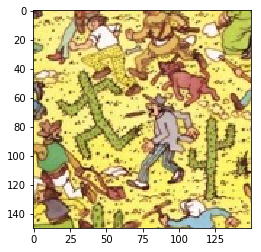

003 0.840311205915 585  1202 1352



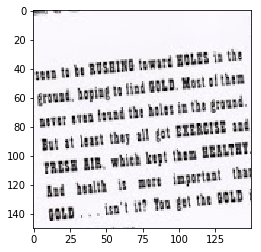

003 0.401771966528 127 277 292 442



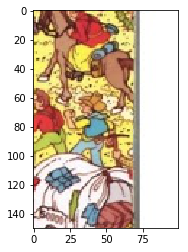

003 0.16557110817 606 756 1499 1599



In [76]:
def svm_probability(train_image_feats, train_labels, test_image_feats):
    categories = list(set(train_labels))
    test_labels = []
    
    clf = SVC(C=2, gamma='scale',probability=True)
    clf.fit(train_image_feats, train_labels)
    test_probabilities = clf.predict_proba(test_image_feats)

    return test_probabilities

def sliding_window(window_size=20, step_size=1):
    f = open('datasets/ImageSets/val.txt')
    wa = open('my_waldo.txt', 'w+')
    we = open('my_wenda.txt', 'w+')
    wi = open('my_wizard.txt', 'w+')
    
    image_id = f.readline().rstrip()
    while image_id:
        image = np.asarray(plt.imread('datasets/JPEGImages/' + image_id + '.jpg'))
        height, width, c = image.shape
        
        test_feats = []
        
#         print((height-window_size) * (width-window_size))
#         print(f"{height},{width}")
        
        #get the keypoints of the image
        #loop through these keypoints only => saves computation time
        orb = cv2.ORB_create()
        img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        kp, des = orb.detectAndCompute(img_gray, None)
        
        ct=0
        for idx in range(len(kp)):
            j,i = kp[idx].pt

            i = int(np.round(i))
            j = int(np.round(j))
#             print(f"{ct}. {i} {j}")
            
            i_limit = i+window_size
            j_limit = j+window_size
            if i_limit >= height:
                i_limit = height-1
            if j_limit >= width:
                j_limit = width-1
            img = image[i:i_limit,j:j_limit]
#             print(f"{i}:{i_limit} {j}:{j_limit}")
            feats = bags_of_sifts(vocab_filename=vocab_filename, img=img)
            test_feats.extend(feats)
            ct += 1

#         print(test_feats)
#         print("--")
        
        #hilda's code: sliding window along entire image
#         test_feats=[]
#         for i in range(0, height-window_size, step_size):
#             for j in range(0, width-window_size, step_size):
#                 img = image[i:i+window_size, j:j+window_size]
#                 feats = bags_of_sifts(vocab_filename=vocab_filename, img=img)
#                 test_feats.extend(feats)
#                 if j==1: 
#                     break
#             break

#         print(len(test_feats))
        predicted_probabilities = svm_probability(training_feats, train_labels, test_feats)
#         print(predicted_probabilities)
        locations = np.argmax(predicted_probabilities, axis=0)
#         print(locations)
        # hilda's code
        conf = np.max(predicted_probabilities, axis=0)
#         print(conf)
        
        for k in range(len(locations)):
            #hilda's code
#             i = locations[k] // (height-window_size)
#             j = locations[k] % (width-window_size)
            j_new, i_new  = kp[locations[k]].pt  # x location of best-fit window of character k
            
            i_new = int(np.round(i_new))
            j_new = int(np.round(j_new))
#             print(f"{locations[k]}. {i_new} {j_new}")
            i_limit_new = i_new+window_size
            j_limit_new = j_new+window_size
            
            if i_limit_new >= height:
                i_limit_new = height-1
            if j_limit_new >= width:
                j_limit_new = width-1
            
            patch = image[i_new:i_limit_new, j_new:j_limit_new]
            plt.imshow(patch, interpolation='nearest')
            plt.show()
            
#             res = image_id + ' ' + str(np.max(predicted_probabilities[locations[k]])) + ' ' + str(i) + ' ' + str(i+window_size) + ' ' + str(j) + ' ' + str(j+window_size) + '\n'
#             print(res)
            if k == 0:
                res = image_id + ' ' + str(predicted_probabilities[locations[k]][k]) + ' ' + str(i_new) + ' '  + ' ' + str(j_new) + ' ' + str(j_limit_new) + '\n'
                print(res)
                wa.write(res)
            if k == 1:
                res = image_id + ' ' + str(np.max(predicted_probabilities[locations[k]][k])) + ' ' + str(i_new) + ' ' + str(i_limit_new) + ' ' + str(j_new) + ' ' + str(j_limit_new) + '\n'
                print(res)
                we.write(res)
            if k == 2:
                res = image_id + ' ' + str(np.max(predicted_probabilities[locations[k]][k])) + ' ' + str(i_new) + ' ' + str(i_limit_new) + ' ' + str(j_new) + ' ' + str(j_limit_new) + '\n'
                print(res)
                wi.write(res)
        break
        image_id = f.readline().rstrip()


sliding_window(150)